# Causal Impact

## 1. コンセプト

Googleが開発した<a href=https://storage.googleapis.com/pub-tools-public-publication-data/pdf/41854.pdf>Causal Impact</a>モデルは、ベイズ構造時系列モデルを観測されたデータに当てはめて動作し、後に、下記に示すように、ある期間に介入が起こらなかった場合の結果を予測するために使用されます。

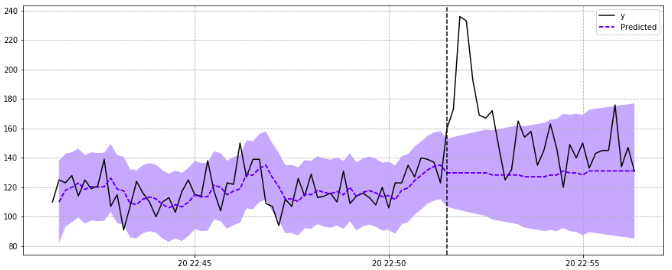

アイデアは、おそらく介入が行われていなければ観察されていたであろうものの参考として、適合したモデル（青色で描かれている）の予測を使用することです。

ベイズ構造時系列モデルは、次の式で表すことができます。

<center>$ y_t = Z^T_t\alpha_t + \beta X_t + G_t\epsilon_t$</center>
<center>$ a_{t+1} = T_t\alpha_t + H_t\eta_t$</center>
<center>$\epsilon_t \sim \mathcal{N}(0, \sigma_t^2)$</center>
<center>$\eta_t \sim \mathcal{N}(0, Q_t)$</center>

$a$は、系列の「状態 」とも呼ばれ、$y_t$は、状態の線形組み合わせに加えて、共変量$X$(およびゼロ平均正規分布に従う測定ノイズ$\epsilon$)を用いた線形回帰です。

行列 $Z$, $T$, $G$, $H$ を変化させることで、時系列のいくつかの異なる振る舞いをモデル化することができます(ARMAやARIMAのようなよりよく知られたものを含む)。

このパッケージ（GoogleのRパッケージも同様です）では、データにフィットさせたい時系列モデルを選択することができます（これについては後述します）。入力としてモデルを使用しない場合は、デフォルトでローカルレベルが構築されており、$y_t$は次のように表されます。

<center>$ y_t = \mu_t + \gamma_t + \beta X_t + \epsilon_t$</center>
<center>$ \mu_{t+1} = \mu_t +  \eta_{\mu, t}$</center>

任意の特定の時点は、「ローカルレベル」成分とも呼ばれるランダムウォーク成分$\mu_t$によって最初にモデル化されます。これは、ランダム性だけをモデル化しているため、他の引数がデータの説明に多くの信号を加えないため、増加します。 不確実性の増大が予想されることを除いて、このコンポーネントに追加される情報はありません。

そして、季節成分をモデル化する $\gamma_t$ があります。このパッケージは、statsmodelsで説明されている頻度モデルと同じモデルを使用しています。

\begin{split}\gamma_t & =  \sum_{j=1}^h \gamma_{j, t} \\
\gamma_{j, t+1} & = \gamma_{j, t}\cos(\lambda_j)
                + \gamma^{*}_{j, t}\sin(\lambda_j) + \omega_{j,t} \\
\gamma^{*}_{j, t+1} & = -\gamma^{(1)}_{j, t}\sin(\lambda_j)
                    + \gamma^{*}_{j, t}\cos(\lambda_j)
                    + \omega^{*}_{j, t}, \\
\omega^{*}_{j, t}, \omega_{j, t} & \sim N(0, \sigma_{\omega^2}) \\
\lambda_j & = \frac{2 \pi j}{s}\end{split}

最後に、共変量の線形回帰である $\beta X_t$ という成分がありますが、これは観測されたデータを説明するのにさらに役立ちます。この成分が予測タスクにうまく機能すればするほど、ローカルレベルの成分は低くなるはずです。

パラメータ$\epsilon_t$は、$y_t$を測定する際のノイズをモデル化したもので、平均値が0、標準偏差が$\sigma_{\epsilon}$の正規分布に従います。

## 2. 使用方法

まずは、コード開発用のノートブックをインポートして準備しておきましょう。

In [1]:
from IPython.core.display import HTML


def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)


css_styling()

In [5]:
%matplotlib inline


import sys
import os


sys.path.append(os.path.abspath('../'))


import numpy as np
import pandas as pd
from IPython.core.pylabtools import figsize
figsize(14, 6)
import statsmodels as sm
from statsmodels.tsa.statespace.structural import UnobservedComponents
from statsmodels.tsa.arima_process import ArmaProcess
from matplotlib import pyplot as plt
from causalimpact import CausalImpact
import warnings


warnings.filterwarnings('ignore')

### 2.1 サンプルデータの生成

In [6]:
# This is an example presented in Google's R code.
np.random.seed(12345)
ar = np.r_[1, 0.9]
ma = np.array([1])
arma_process = ArmaProcess(ar, ma)

x0 = 100 + arma_process.generate_sample(nsample=100)
x1 = 90 + arma_process.generate_sample(nsample=100)
y = 1.2 * x0 + 0.9 * x1 + np.random.normal(size=100)
y[70:] += 5
data = pd.DataFrame({'x0': x0, 'x1': x1, 'y': y}, columns=['y', 'x0', 'x1'])

data.plot()
plt.axvline(69, linestyle='--', color='k')
plt.legend();

### 2.1 デフォルトモデルの使用

In [7]:
pre_period = [0, 69]
post_period = [70, 99]

ci = CausalImpact(data, pre_period, post_period)

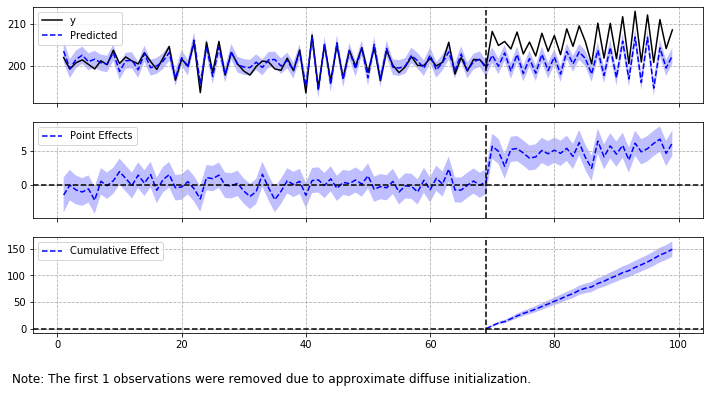

In [8]:
ci.plot(figsize=(12, 6))

結果をプロットする場合，デフォルトでは3つのグラフが表示されます．
  - 「元の」系列と予測された系列の比較
  - 「点効果（points effects）」（元の系列と予測された系列の差）
  - 最後に「累積」効果ですが、これは基本的には時間をかけて蓄積されたポイント効果の合計です。


表示するパネルを選択することができます。ここでは、元の系列とその点ごとの効果を表示した例を示しています。

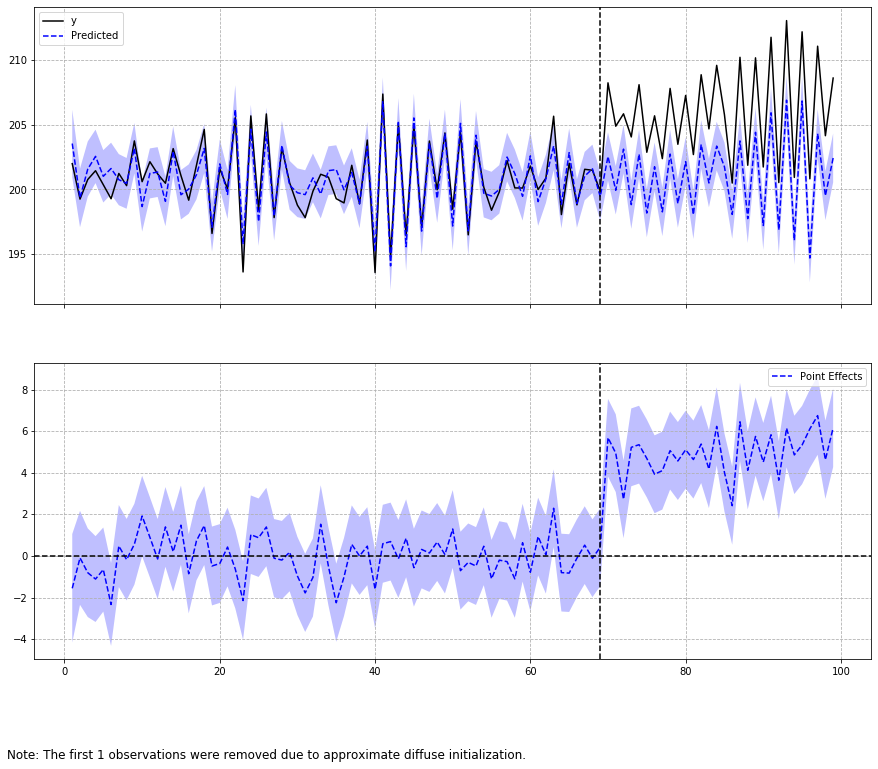

In [9]:
ci.plot(panels=['original', 'pointwise'], figsize=(15, 12))

一般的な結果や数値を表示するためには、`summary` メソッドをデフォルトまたは、より詳細な観察効果の説明を表示する"report"のどちらかで呼び出すことができます。

In [10]:
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    206.0              6179.6
Prediction (s.d.)         201.0 (0.2)        6031.0 (7.3)
95% CI                    [200.6, 201.5]     [6016.5, 6045.0]

Absolute effect (s.d.)    5.0 (0.2)          148.6 (7.3)
95% CI                    [4.5, 5.4]         [134.6, 163.0]

Relative effect (s.d.)    2.5% (0.1%)        2.5% (0.1%)
95% CI                    [2.2%, 2.7%]       [2.2%, 2.7%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.00%

For more details run the command: print(impact.summary('report'))


例えば、ここでは、観察された絶対効果が5.0であり、その予測は4.5から5.4まで95%信頼区間で変化していることがわかります。

これらの結果を観察する際に考慮すべき非常に重要な数値は、`p-value`、または（単なるノイズではなく）実際に因果関係のある効果がある確率です。結論を出す前に、この値を分析に使用することを忘れないでください!

より詳細な要約が必要な場合は、以下を実行してください。

In [11]:
print(ci.summary(output='report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 206.0. By contrast, in the absence of an
intervention, we would have expected an average response of 201.0.
The 95% interval of this counterfactual prediction is [200.6, 201.5].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 5.0 with a 95% interval of
[4.5, 5.4]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 6179.6.
By contrast, had the intervention not taken place, we would have expected
a sum of 6031.0. The 95% interval of this prediction is [6016.5, 6045.0].


The above results are given in terms of absolute numbers. In relative
terms, the response variable sho

`ci`オブジェクトは、フィッティングプロセスのすべての結果も保持します。結果をさらに分析したい場合は、これらのすべての値にアクセスすることもできます。

In [12]:
ci.inferences.head()

post_cum_y       preds  post_preds  post_preds_lower  post_preds_upper  \
0         NaN  199.256404         NaN               NaN               NaN   
1         NaN  203.542200         NaN               NaN               NaN   
2         NaN  199.344827         NaN               NaN               NaN   
3         NaN  201.573546         NaN               NaN               NaN   
4         NaN  202.552743         NaN               NaN               NaN   

   preds_lower  preds_upper  post_cum_pred  post_cum_pred_lower  \
0 -5316.556223  5715.069030            NaN                  NaN   
1   200.933131   206.151269            NaN                  NaN   
2   197.085073   201.604581            NaN                  NaN   
3   199.442809   203.704282            NaN                  NaN   
4   200.489453   204.616032            NaN                  NaN   

   post_cum_pred_upper  point_effects  point_effects_lower  \
0                  NaN       1.216337         -5514.596290   
1                  NaN      -1.552851            -4.161920   
2                  NaN      -0.090130            -2.349884   
3                  NaN      -0.804714            -2.935450   
4                  NaN      -1.108351            -3.171640   

   point_effects_upper  post_cum_effects  post_cum_effects_lower  \
0          5517.028963               NaN                     NaN   
1             1.056218               NaN                     NaN   
2             2.169623               NaN                     NaN   
3             1.326022               NaN                     NaN   
4             0.954939               NaN                     NaN   

   post_cum_effects_upper  
0                     NaN  
1                     NaN  
2                     NaN  
3                     NaN  
4                     NaN

また、訓練されたモデルに関連する情報を取得することもできます（フィットしたパラメータが何であったかなど）。

In [13]:
ci.trained_model.params

sigma2.irregular    0.111837
sigma2.level        0.000069
beta.x0             0.945247
beta.x1             0.502555
dtype: float64

また、レベルパラメータ（または境界線を設定したい任意のパラメータ）の標準偏差に対する事前の値を選択することも可能です。以下に例を示します。

In [14]:
ci = CausalImpact(data, pre_period, post_period, prior_level_sd=0.1)

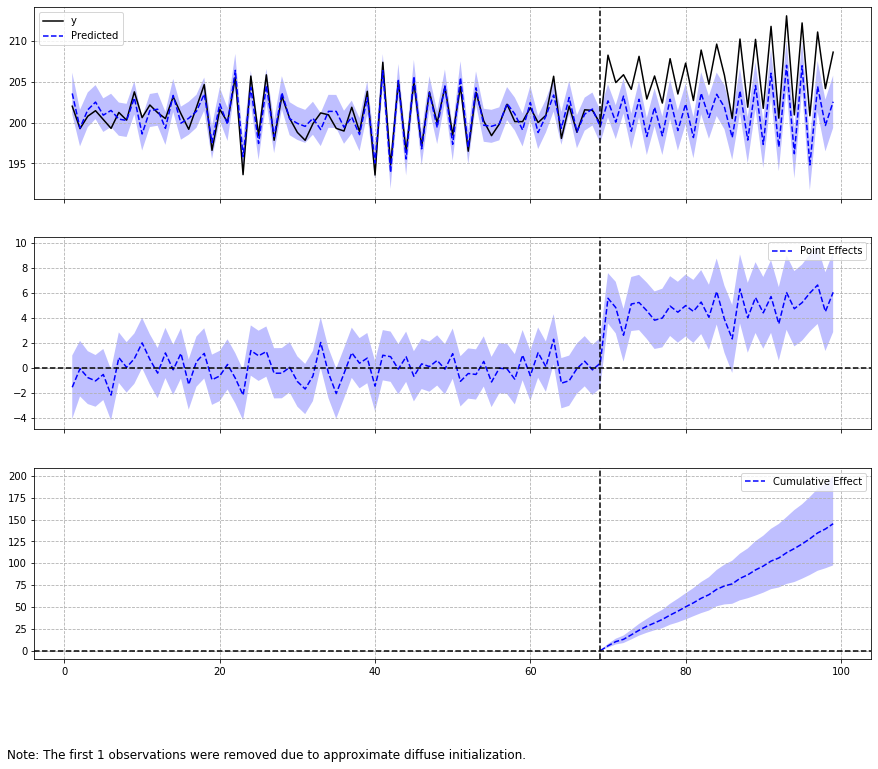

In [15]:
ci.plot(figsize=(15, 12))

デフォルト値は $0.01$ で、分散が小さく、共変量によってよく説明されたデータを表します。与えられた入力データがそうではないことが判明した場合、データのこのパターンを反映するために、ローカルレベルの標準偏差の前の値を変更することができます。値 $0.1$ の場合、基本的に、共変量自体では説明できないランダムウォークの強い成分がデータに存在することを示しています。

データ内の季節成分をモデル化することも可能です。まず、<a href=https://github.com/statsmodels/statsmodels/blob/master/examples/notebooks/statespace_seasonal.ipynb>statsmodels パッケージ</a>で利用できる季節シミュレーターを使ってみましょう。

In [16]:
def simulate_seasonal_term(periodicity, total_cycles, noise_std=1.,
                           harmonics=None):
    duration = periodicity * total_cycles
    assert duration == int(duration)
    duration = int(duration)
    harmonics = harmonics if harmonics else int(np.floor(periodicity / 2))

    lambda_p = 2 * np.pi / float(periodicity)

    gamma_jt = noise_std * np.random.randn((harmonics))
    gamma_star_jt = noise_std * np.random.randn((harmonics))

    total_timesteps = 100 * duration # Pad for burn in
    series = np.zeros(total_timesteps) 
    for t in range(total_timesteps):
        gamma_jtp1 = np.zeros_like(gamma_jt)
        gamma_star_jtp1 = np.zeros_like(gamma_star_jt)
        for j in range(1, harmonics + 1):
            cos_j = np.cos(lambda_p * j)
            sin_j = np.sin(lambda_p * j)
            gamma_jtp1[j - 1] = (gamma_jt[j - 1] * cos_j
                                 + gamma_star_jt[j - 1] * sin_j
                                 + noise_std * np.random.randn())
            gamma_star_jtp1[j - 1] = (- gamma_jt[j - 1] * sin_j
                                      + gamma_star_jt[j - 1] * cos_j
                                      + noise_std * np.random.randn())
        series[t] = np.sum(gamma_jtp1)
        gamma_jt = gamma_jtp1
        gamma_star_jt = gamma_star_jtp1
    wanted_series = series[-duration:] # Discard burn in

    return wanted_series

In [18]:
duration = 100
periodicities = [7, 30]
num_harmonics = [2, 5]
std = np.array([0.1, 0.1])
# np.random.seed(8678309)

terms = []
for ix, _ in enumerate(periodicities):
    s = simulate_seasonal_term(
        periodicities[ix],
        duration / periodicities[ix],
        harmonics=num_harmonics[ix],
        noise_std=std[ix])
    terms.append(s)
terms.append(np.ones_like(terms[0]) * 10.)
seasons = pd.Series(np.sum(terms, axis=0))

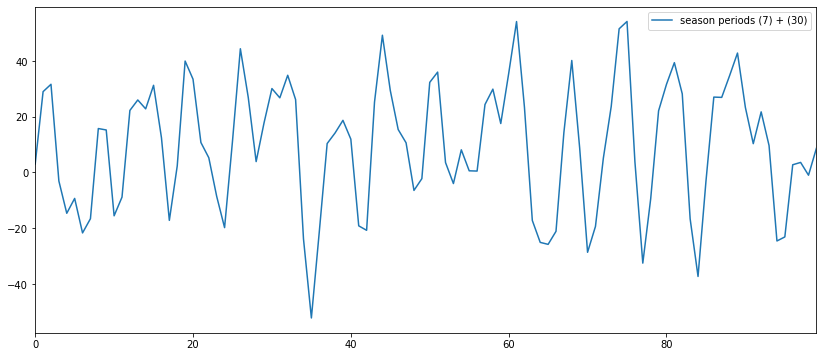

In [19]:
seasons.plot(label='season periods (7) + (30)', legend=True);

In [20]:
season_data = data.copy()
season_data['y'] += seasons

In [21]:
ci = CausalImpact(season_data, pre_period, post_period,
                  nseasons=[{'period': 7, 'harmonics': 2}, {'period': 30, 'harmonics': 5}])

In [23]:
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    215.2              6455.4
Prediction (s.d.)         211.0 (0.8)        6329.4 (24.5)
95% CI                    [209.4, 212.6]     [6282.4, 6378.5]

Absolute effect (s.d.)    4.2 (0.8)          125.9 (24.5)
95% CI                    [2.6, 5.8]         [76.9, 172.9]

Relative effect (s.d.)    2.0% (0.4%)        2.0% (0.4%)
95% CI                    [1.2%, 2.7%]       [1.2%, 2.7%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.00%

For more details run the command: print(impact.summary('report'))


### 2.2 日付のインデックスを使った取り組み

モデルは、日次データでも動作するはずです。入力データが日付をインデックスタイプとして持つ場合にどうなるか見てみましょう。

In [24]:
dated_data = data.set_index(pd.date_range(start='20180101', periods=len(data)))

pre_period = ['20180101', '20180311']
post_period = ['20180312', '20180410']

figsize = (20, 6)
ci = CausalImpact(dated_data, pre_period, post_period)

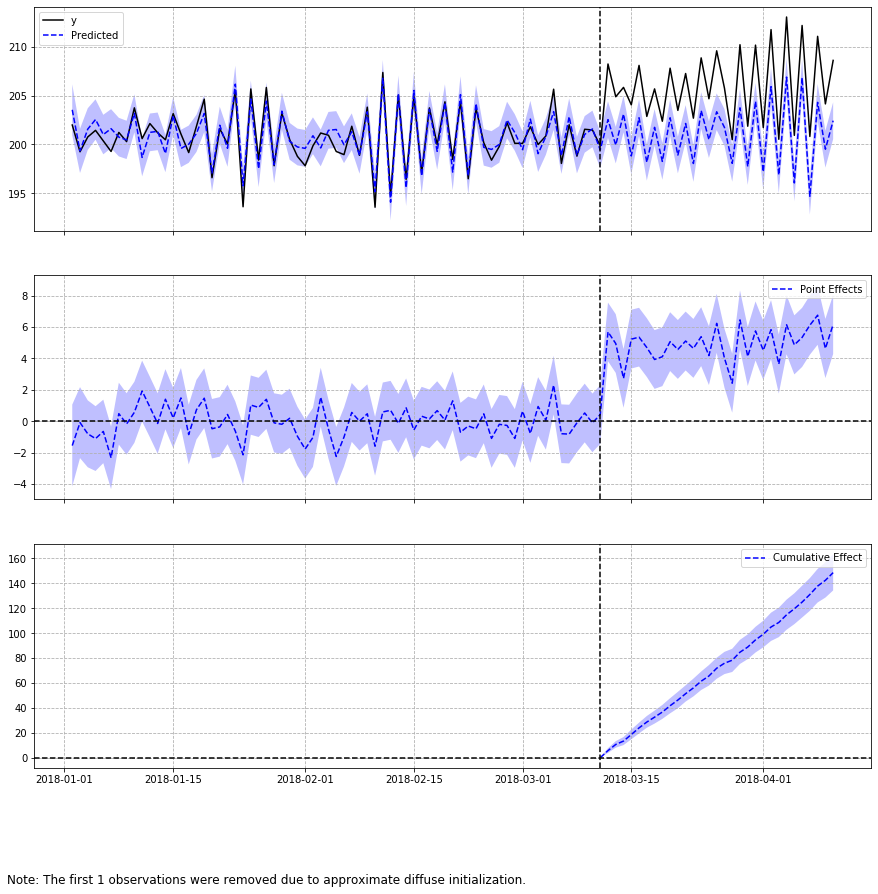

In [25]:
ci.plot(figsize=(15, 14))

In [25]:
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    206.0              6179.6
Prediction (s.d.)         201.0 (0.2)        6031.0 (6.8)
95% CI                    [200.6, 201.5]     [6018.0, 6044.8]

Absolute effect (s.d.)    5.0 (0.2)          148.6 (6.8)
95% CI                    [4.5, 5.4]         [134.8, 161.6]

Relative effect (s.d.)    2.5% (0.1%)        2.5% (0.1%)
95% CI                    [2.2%, 2.7%]       [2.2%, 2.7%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.00%

For more details run the command: print(impact.summary('report'))


### 2.3 カスタマイズされたモデル

GoogleのRパッケージと同じように、ここでは介入前の期間に学習させるカスタマイズされたモデルを選択することもできます。ここで注意したいのは、データを標準化したい場合、カスタマイズされたモデルはすでに標準化されているデータを用いて構築され、入力データ`data`は次のように元の正規化されていないデータでなければならないということです。

In [27]:
from causalimpact.misc import standardize


normed_pre_data, _ = standardize(data.iloc[:70])

model = UnobservedComponents(
    endog=normed_pre_data.iloc[:70, 0],
    level='llevel',
    exog=normed_pre_data.iloc[:70, 1:]
)

pre_period = [0, 69]
post_period = [70, 99]

ci = CausalImpact(data, pre_period, post_period, model=model)

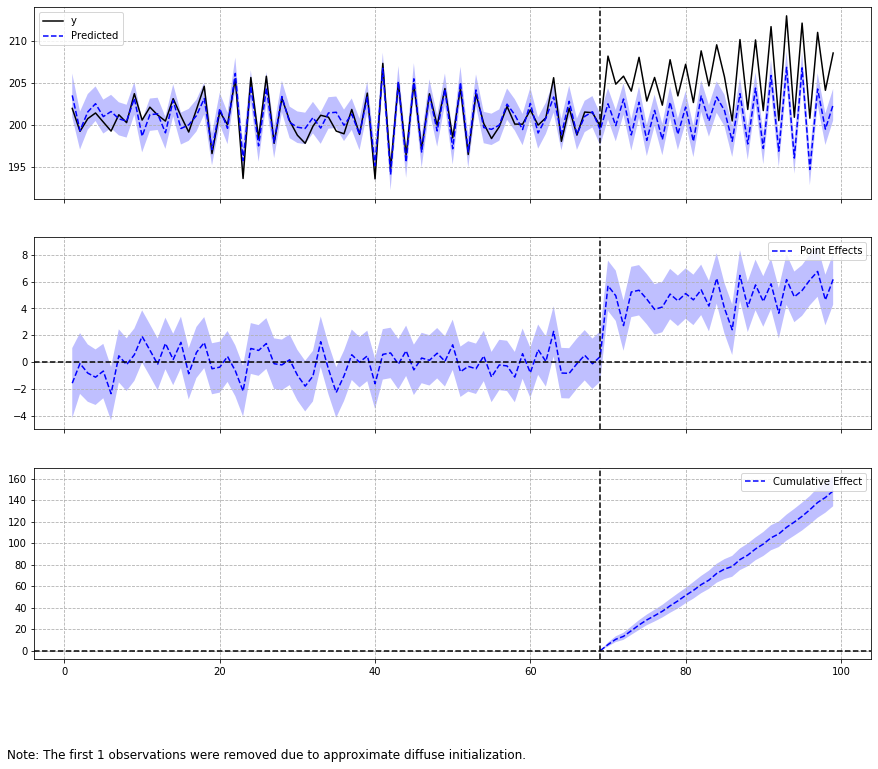

In [28]:
ci.plot(figsize=(15, 12))

In [23]:
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    206.0              6179.6
Prediction (s.d.)         201.0 (0.2)        6031.0 (7.4)
95% CI                    [200.5, 201.5]     [6016.3, 6045.2]

Absolute effect (s.d.)    5.0 (0.2)          148.6 (7.4)
95% CI                    [4.5, 5.4]         [134.4, 163.3]

Relative effect (s.d.)    2.5% (0.1%)        2.5% (0.1%)
95% CI                    [2.2%, 2.7%]       [2.2%, 2.7%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.00%

For more details run the command: print(impact.summary('report'))


In [28]:
ci.trained_model.params

sigma2.irregular    0.111837
sigma2.level        0.000069
beta.x0             0.945247
beta.x1             0.502555
dtype: float64

### 2.5 結果を理解する

これはモデルからの結果を理解するためのより洗練されたアプローチですが、訓練されたモデルのメトリクスを表示して、それがなぜそのように適合したのかを確認することができます。

In [31]:
dated_data = data.set_index(pd.date_range(start='20180101', periods=len(data)))

pre_period = ['20180101', '20180311']
post_period = ['20180312', '20180410']

ci = CausalImpact(dated_data, pre_period, post_period)

ローカルレベルのモデルは、ノイズ$\epsilon$、ランダムウォーク(level)、線形回帰(beta.X)を使用して構築されていることを覚えておいてください。時々、beta.Xの値が何であるかを見たくなるでしょう: それが小さすぎる場合、おそらく、あなたがモデルで使用した共変量は$y_t$を説明するのにあまり役に立っていないでしょう。

In [75]:
ci.trained_model.params

sigma2.irregular    0.111837
sigma2.level        0.000069
beta.x0             0.945247
beta.x1             0.502555
dtype: float64

おわかりのように、β.Xは、応答変数で観察されることの多くを説明するのに役立ちます。データに共変量として全ランダム変数を追加すると何が起こるか見てみましょう。

In [33]:
x2 = pd.DataFrame(np.random.randn(100, 1), columns=['x2'])
data2 = pd.concat([data, x2], axis=1)

In [34]:
pre_period = [0, 69]
post_period = [70, 99]
ci = CausalImpact(data2, pre_period, post_period)

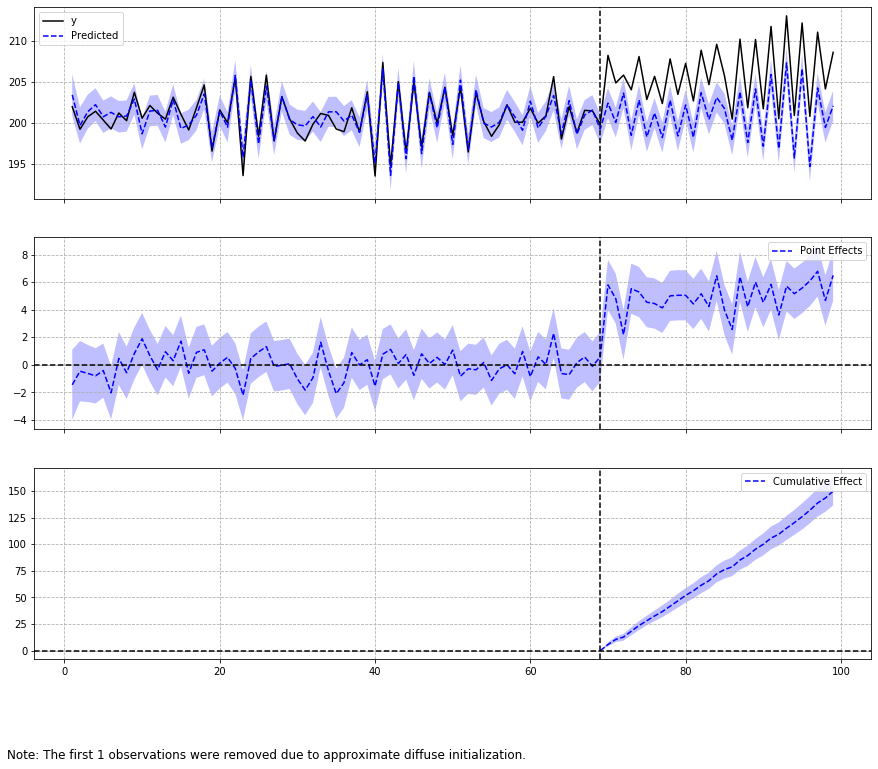

In [35]:
ci.plot(figsize=(15, 12))

In [36]:
ci.trained_model.params

sigma2.irregular    0.105522
sigma2.level        0.000069
beta.x0             0.942688
beta.x1             0.491892
beta.x2             0.079763
dtype: float64

$\beta_{x_2}$は、観測されたデータと関係のない完全なランダム変数から期待されるように、$y_t$を説明するのに役に立ちません。

ここで、実際のデータを使った一例をご紹介します。

In [37]:
gdata = pd.read_csv('../tests/fixtures/google_data.csv')
gdata.index = pd.to_datetime(gdata['t'])
del gdata['t']

In [38]:
pre_period = ['2016-02-20 22:41:20', '2016-02-20 22:51:20']
post_period = ['2016-02-20 22:51:30', '2016-02-20 22:56:20']

ci = CausalImpact(gdata, pre_period, post_period)

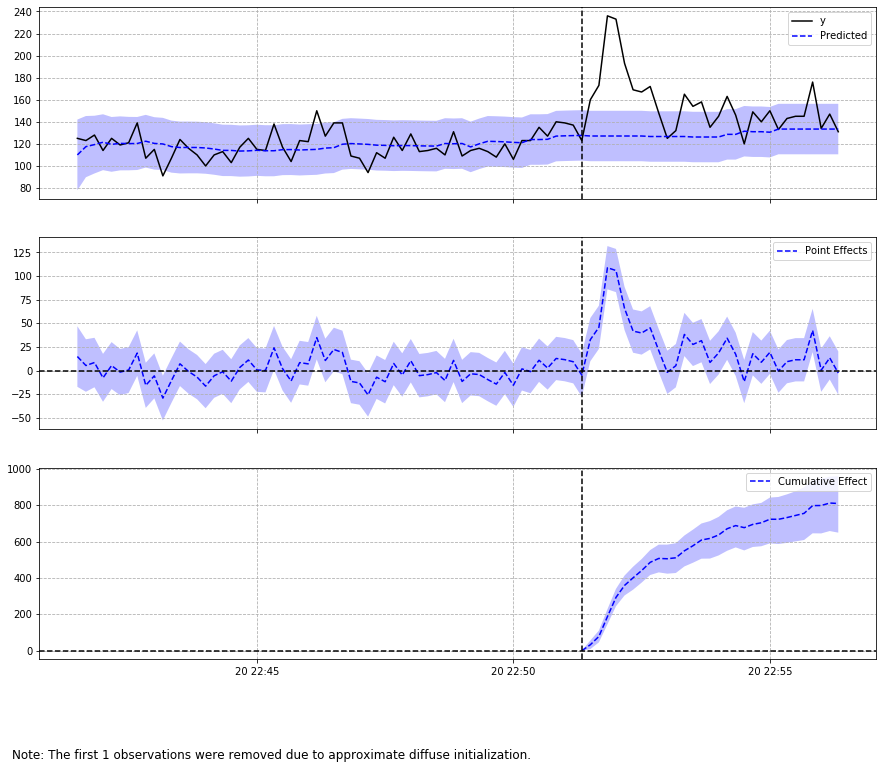

In [39]:
ci.plot(figsize=(15, 12))

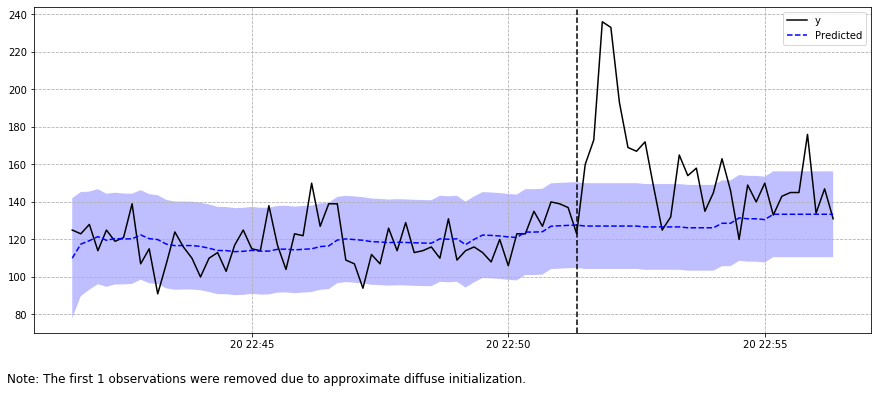

In [40]:
ci.plot(figsize=(15, 6), panels=['original'])

In [84]:
ci.trained_model.params

sigma2.irregular    0.940607
sigma2.level        0.000069
beta.x1             0.134246
beta.x2            -0.371246
dtype: float64

In [85]:
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    156.2              4687.0
Prediction (s.d.)         129.2 (2.6)        3876.8 (76.9)
95% CI                    [124.3, 134.3]     [3727.7, 4029.1]

Absolute effect (s.d.)    27.0 (2.6)         810.2 (76.9)
95% CI                    [21.9, 32.0]       [657.9, 959.3]

Relative effect (s.d.)    20.9% (2.0%)       20.9% (2.0%)
95% CI                    [17.0%, 24.7%]     [17.0%, 24.7%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.00%

For more details run the command: print(impact.summary('report'))


上の例は、ローカルレベルのパラメータに予備知識を設定することが最終的な結果に与える効果を見るのに良いものです。オプティマイザに自動的に値を見つけさせると、次のようになります。

In [43]:
ci = CausalImpact(gdata, pre_period, post_period, prior_level_sd=None)

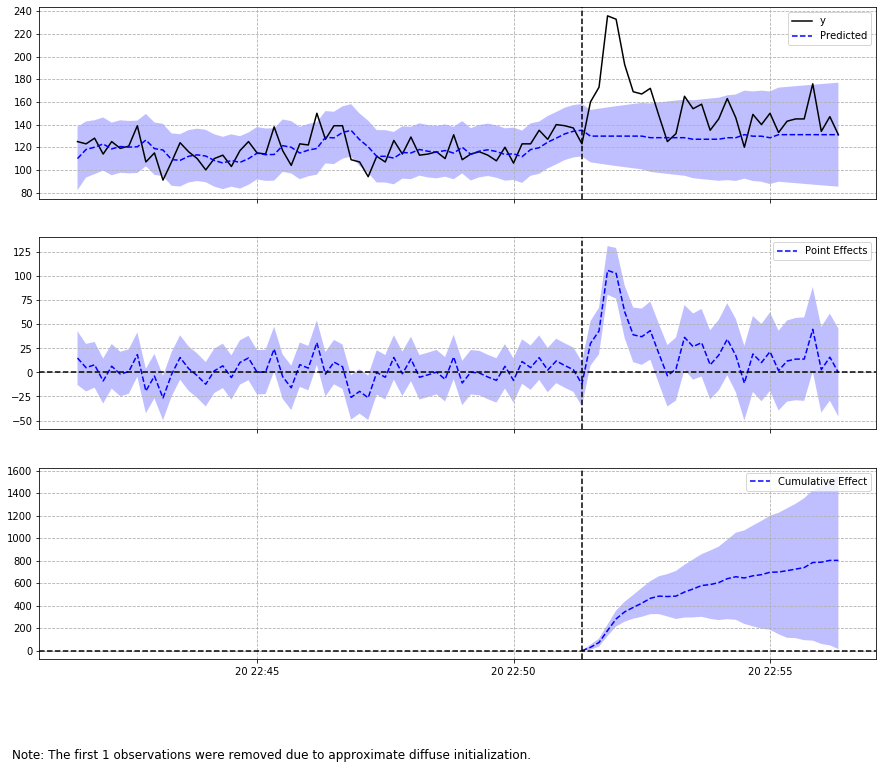

In [44]:
ci.plot(figsize=(15, 12))

In [46]:
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    156.2              4687.0
Prediction (s.d.)         129.5 (13.1)       3883.9 (392.0)
95% CI                    [104.5, 155.8]     [3136.0, 4672.7]

Absolute effect (s.d.)    26.8 (13.1)        803.1 (392.0)
95% CI                    [0.5, 51.7]        [14.3, 1551.0]

Relative effect (s.d.)    20.7% (10.1%)      20.7% (10.1%)
95% CI                    [0.4%, 39.9%]      [0.4%, 39.9%]

Posterior tail-area probability p: 0.022
Posterior prob. of a causal effect: 97.80%

For more details run the command: print(impact.summary('report'))


In [42]:
ci.trained_model.params

sigma2.irregular    0.667721
sigma2.level        0.099363
beta.x1             0.405506
beta.x2            -0.353930
dtype: float64

上記のように、レベルの分散が少し高くなっているため、以前よりも信頼区間が広くなっています。

### 2.6 その他の実データの例

(this is inspired in the issue <a href=https://github.com/dafiti/causalimpact/issues/31>31</a> created by user **mg515**)

このセクションでは、2015年9月に起きた<a href=https://en.wikipedia.org/wiki/Volkswagen_emissions_scandal>排出ガススキャンダル</a>後のフォルクスワーゲン社が受けた影響を見つけるために、3つの大企業、フォルクスワーゲン社、BMW社とアリアンツ社の株価で作業していきます。

手始めに、データを読み込んでみましょう。

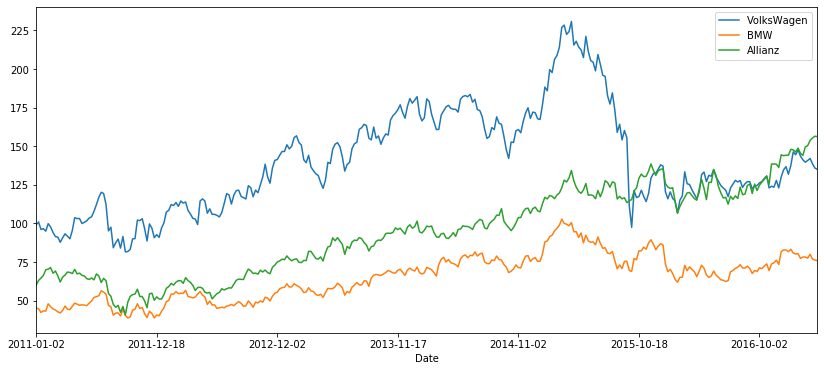

In [48]:
data = pd.read_csv('../tests/fixtures/volks_data.csv', header=0, sep=' ', index_col='Date')
data.plot();

まず、2015年9月頃にフォルクスワーゲンの株価が急落しているように見えるのに対し、他の系列は観測された過去の行動を維持していることがわかります。これは、VW株のあるべき姿を予測するのに両銘柄を独立変数として使うことができることを示しているようです。

まずは、VW の株価のみを考慮した因果推論を実行してみましょう。

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    126.9              10026.1
Prediction (s.d.)         184.7 (3.6)        14588.4 (287.9)
95% CI                    [177.7, 192.0]     [14041.4, 15169.9]

Absolute effect (s.d.)    -57.8 (3.6)        -4562.3 (287.9)
95% CI                    [-65.1, -50.8]     [-5143.8, -4015.3]

Relative effect (s.d.)    -31.3% (2.0%)      -31.3% (2.0%)
95% CI                    [-35.3%, -27.5%]   [-35.3%, -27.5%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.00%

For more details run the command: print(impact.summary('report'))


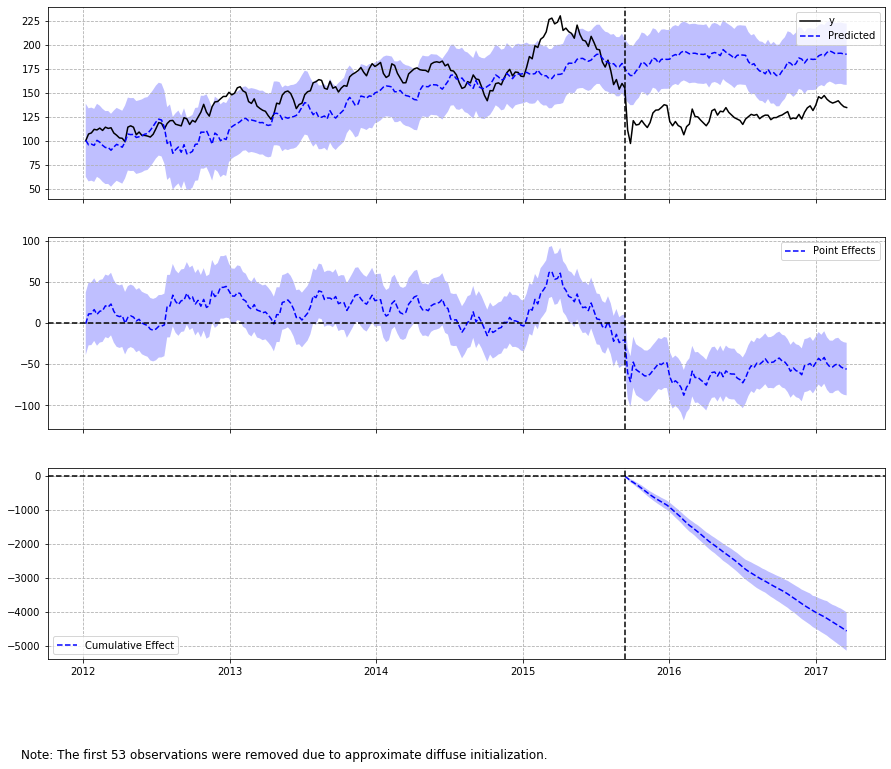

In [49]:
pre_period = [np.min(data.index.values), "2015-09-13"]
post_period = ["2015-09-20", np.max(data.index.values)]

ci = CausalImpact(data.iloc[:, 0], pre_period, post_period, nseasons=[{'period': 52}])

print(ci.summary())
ci.plot()

このモデルは、選択した期間の後に起こった因果関係が確かにあったことを主張します。

しかし、考慮すべき1つの点があります。：GoogleのRアルゴリズムを実行して得られる結果と異なる結果が出てくるでしょう。


<code>
    
    Posterior inference {CausalImpact}

                         Average        Cumulative    
Actual                   127            9915          
Prediction (s.d.)        166 (23)       12963 (1824)  
95% CI                   [122, 213]     [9483, 16614] 
                                                      
Absolute effect (s.d.)   -39 (23)       -3048 (1824)  
95% CI                   [-86, 5.5]     [-6699, 432.2]
                                                      
Relative effect (s.d.)   -24% (14%)     -24% (14%)    
95% CI                   [-52%, 3.3%]   [-52%, 3.3%]  

Posterior tail-area probability p:   0.05269
Posterior prob. of a causal effect:  95%

For more details, type: summary(impact, "report")

</code>

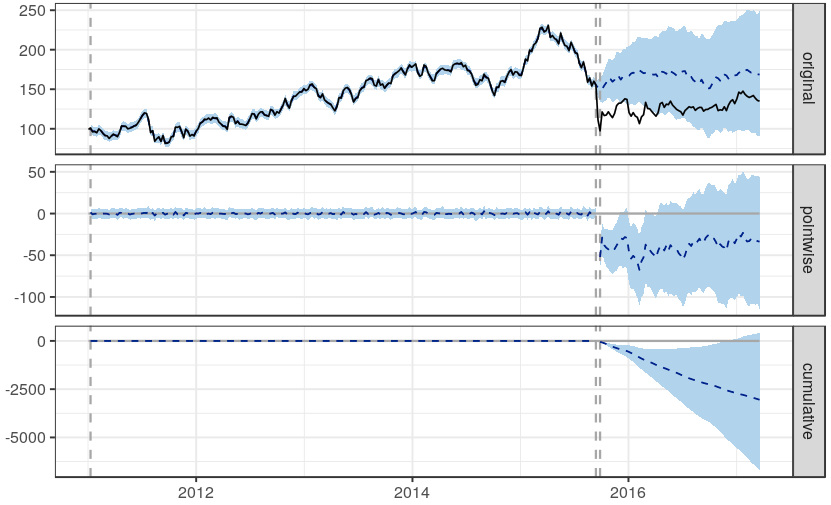

このPythonのパッケージでは、prior_level_sdは非常に制限的であり、これはモデルをフィッティングする際に事前知識が強い重みを持っているとも言えます。

また、このPythonの実装では、データがどのように振る舞うのか納得できる場合にのみprior_level_sdを使うべきであり、そうでない場合は `None` のままにしておくことができ、パッケージは最尤推定を使ってこのパラメータを最適化してくれます。そうするとどうなるか見てみましょう。

In [50]:
ci = CausalImpact(data.iloc[:, 0], pre_period, post_period, prior_level_sd=None, nseasons=[{'period': 52}])

print(ci.summary())
ci.plot()

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    126.9              10026.1
Prediction (s.d.)         166.6 (27.3)       13160.5 (2153.2)
95% CI                    [113.0, 219.8]     [8927.5, 17368.0]

Absolute effect (s.d.)    -39.7 (27.3)       -3134.5 (2153.2)
95% CI                    [-92.9, 13.9]      [-7341.9, 1098.6]

Relative effect (s.d.)    -23.8% (16.4%)     -23.8% (16.4%)
95% CI                    [-55.8%, 8.3%]     [-55.8%, 8.3%]

Posterior tail-area probability p: 0.09
Posterior prob. of a causal effect: 91.01%

For more details run the command: print(impact.summary('report'))


そして、基本的に同じ結果を得ることができました。両方のモデルは、やや強いランダムウォーク成分（ローカルレベルのパラメータで表される）にフィットし、39の絶対効果を観測しています。

続いてデータを説明するための独立変数として他の株価を使用した場合に何が起こるかを見てみましょう。

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    126.9              10026.1
Prediction (s.d.)         175.2 (2.9)        13843.4 (231.4)
95% CI                    [169.6, 181.1]     [13396.3, 14303.2]

Absolute effect (s.d.)    -48.3 (2.9)        -3817.3 (231.4)
95% CI                    [-54.1, -42.7]     [-4277.2, -3370.2]

Relative effect (s.d.)    -27.6% (1.7%)      -27.6% (1.7%)
95% CI                    [-30.9%, -24.3%]   [-30.9%, -24.3%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.00%

For more details run the command: print(impact.summary('report'))


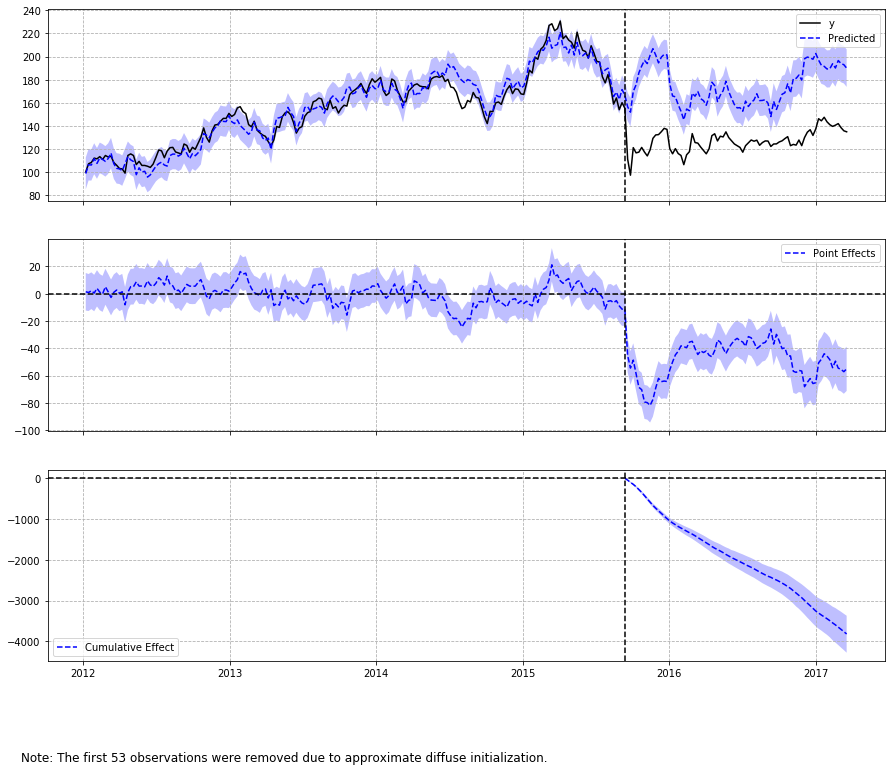

In [51]:
ci = CausalImpact(data, pre_period, post_period, nseasons=[{'period': 52}])

print(ci.summary())
ci.plot()

モデルをローカルレベルのパラメータを最適化するようにさせたいのであれば、以下に結果があります。

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    126.9              10026.1
Prediction (s.d.)         165.5 (15.6)       13077.3 (1231.3)
95% CI                    [135.5, 196.6]     [10701.3, 15527.9]

Absolute effect (s.d.)    -38.6 (15.6)       -3051.2 (1231.3)
95% CI                    [-69.6, -8.5]      [-5501.9, -675.3]

Relative effect (s.d.)    -23.3% (9.4%)      -23.3% (9.4%)
95% CI                    [-42.1%, -5.2%]    [-42.1%, -5.2%]

Posterior tail-area probability p: 0.003
Posterior prob. of a causal effect: 99.70%

For more details run the command: print(impact.summary('report'))


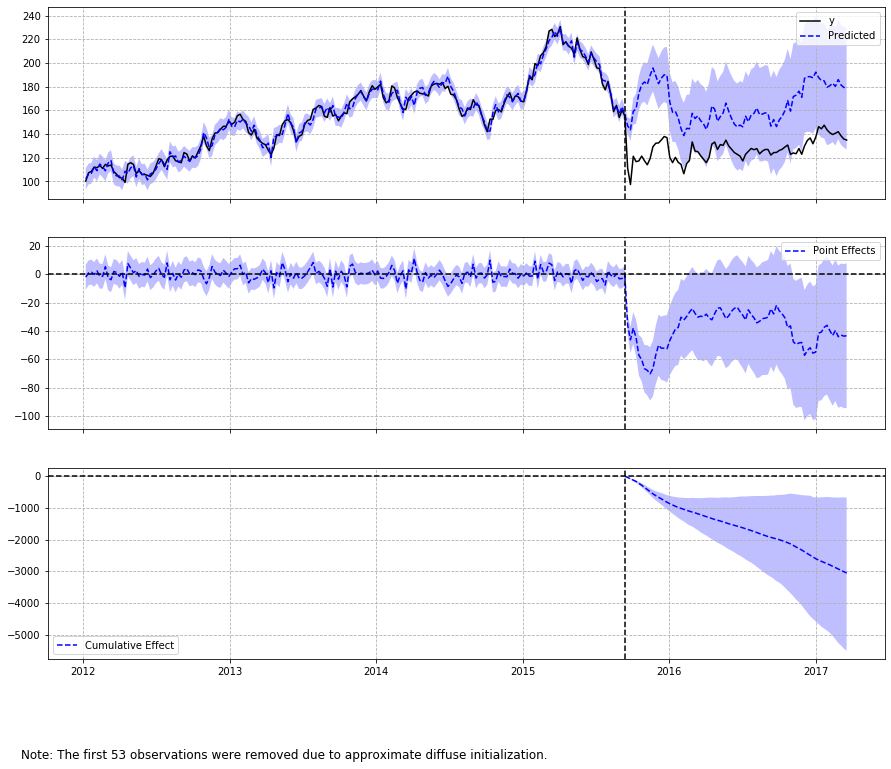

In [52]:
ci = CausalImpact(data, pre_period, post_period, prior_level_sd=None, nseasons=[{'period': 52}])

print(ci.summary())
ci.plot()

読者の方も同じ結論に達するでしょうが、制限する閾値がないためPythonパッケージはレベル値に対してより強いコンポーネントを適合すると予想されます。これは、レベルパラメータには何の仮定もないので、Pythonでは好ましい動作です。

### 2.7 TODOリスト

- ベイズ回帰の計算が最終的な要約にどれほど役立つかを調査する必要があります。